# 자체 평가지표
* 가지고 있는 제출 파일과 비교

In [48]:
import pandas as pd
from tqdm import tqdm

In [49]:
# 판다스 라이브러리에서 과학적 표기 사용 안하기
pd.options.display.float_format = '{:.5f}'.format
# 리셋 
# pd.reset_option('display.float_format')

In [50]:
import platform
from matplotlib import font_manager, rc
import matplotlib.pyplot as plt
import seaborn as sns

path = "C:/Windows/Fonts/malgun.ttf"
if platform.system() == "Windows":
    font_name = font_manager.FontProperties(fname=path).get_name()
    rc('font', family=font_name)
elif platform.system()=="Darwin":
    rc('font', family='AppleGothic')
else:
    print("Unknown System")

### 평가 지표 함수화

In [51]:
def evaluation_index(before_sub, present_sub):
    # 전 최고 제출 파일 열 정리
    before_sub[['일자', '시간', '구분']] = before_sub['일자|시간|구분'].str.split(' ').to_list()
    before_sub = before_sub.drop('일자|시간|구분', axis=1)
    before_sub = before_sub[['일자', '시간', '구분', '공급량']]
    # 현재 제출 파일 열 정리
    present_sub[['일자', '시간', '구분']] = present_sub['일자|시간|구분'].str.split(' ').to_list()
    present_sub = present_sub.drop('일자|시간|구분', axis=1)
    present_sub = present_sub[['일자', '시간', '구분', '공급량']]

    eval_set = pd.DataFrame(['MSE','RMSE', 'MAE', 'R2','NMAE'], columns=['평가지표'])
    for division in tqdm(present_sub['구분'].unique()):
        temp_before_sub = before_sub[before_sub['구분'] == division]
        temp_present_sub = present_sub[present_sub['구분'] == division]

        # 전 제출 값 = 실제값 취급
        # 현제 제출 값 = 예측값
        y = temp_before_sub['공급량']
        pred = temp_present_sub['공급량']
        y_mean = y.mean()

        # MSE
        mse = ( ( y - pred) ** 2 ).sum() / len(pred)
            
        # RMSE
        rmse = mse ** (1/2)
        
        # MAE
        mae = ( abs( y - pred ) ).sum() / len(pred)
        
        # R2
        upper = ( (y - pred) ** 2 ).sum()
        lower = ( (y - y_mean) ** 2 ).sum()
        if lower == 0:
            fraction = 0
        else:
            fraction = upper / lower
        r2 = 1 - fraction
        
        #NMAE(Normalized Mean Absolute Error)-정규화 평균 절대 오차 척도
        nmae = ( abs( y - pred ) / y ).sum() / len(pred)
        
        # 평가지표 리스트
        one_eval_set = [mse, rmse, mae, r2, nmae]
        
        # 평가지표 셋에 담기
        eval_set[division] = one_eval_set

    # 평가지표 평균 구하기
    eval_set['평가지표_평균'] = eval_set.mean(axis=1)

    # 평가지표 평균 출력
    print(eval_set[['평가지표', '평가지표_평균']])
    
    return eval_set

## NAE 평가 지표 셋 함수화

In [52]:
def nae_set(before_sub, present_sub):
    # 일자 시간을 한번에 지정할 수 있게 편집
    before_sub[['일자', '시간', '구분']] = before_sub['일자|시간|구분'].str.split(' ').tolist()
    before_sub['일자|시간'] = before_sub['일자'] + ' ' + before_sub['시간']
    before_sub['예측공급량'] = present_sub['공급량']

    eval_set = pd.DataFrame()
    # 예측 값 구분별로 평가하기
    for division in tqdm(before_sub['구분'].unique()):
        # 구분별로 데이터 가져오기
        temp_before_sub = before_sub[before_sub['구분'] == division]

        # 전 최고 제출 값 = 실제값 취급
        # 현재 제출 값 = 예측값
        y = temp_before_sub['공급량']
        pred = temp_before_sub['예측공급량']
        
        #NAE(Normalized Absolute Error)-정규화 절대 오차 척도(NMAE에서 평균을 취하지 않음)
        temp_before_sub['NAE'] = abs( y - pred ) / y 
        
        # 평가지표 셋에 담기
        eval_set = pd.concat([eval_set, temp_before_sub], ignore_index=True)
    
        # 평가지표 셋의 열 정리
        eval_set = eval_set[['일자|시간', '구분', '공급량', '예측공급량', 'NAE']]
    return eval_set

## NAE 조건에 따른 샘플 시각화 

In [53]:
def vis_nae(res_df, res_num):
    # 얼마 이상의 NAE 샘플을 설정
    num = res_num
    res_df = all_nae[all_nae['NAE'] >= num]
    print(f"총 NAE {num}이상 샘플 개수 :",len(res_df['NAE']))

    # 구분별로 그래프(총 구분 7개 : 'A', 'B', 'C', 'D', 'E', 'G', 'H')
    for div in tqdm(res_df['구분'].unique()):
        temp = res_df[res_df['구분']==div]
        print(f"구분 {div}의 NAE {num}이상 샘플 개수 :",len(temp['NAE']))
        
        plt.figure(figsize=(16,10))
        plt.title(f'구분 : {div} NAE : {num}이상', fontdict={'size':20})
        plt.xticks(fontsize=15, rotation=90)
        plt.yticks(fontsize=15)
        x = temp['일자|시간']
        y1 = temp['공급량']
        y2 = temp['예측공급량']
        plt.plot(x, y1, 'b', label='공급량')
        plt.plot(x, y2, 'r', label='예측공급량')
        plt.legend(loc='upper right', fontsize=15)

# 데이터 가져오기

In [54]:
# sub24_pycaret12.csv
# sub32_pycaret20.csv
# pycaret_robust_3models.csv

# 최고점 제출 파일
before_sub = pd.read_csv('../07_결과_출력/pycaret_robust_3models.csv')
# 현재 제출 파일
present_sub = pd.read_csv('../07_결과_출력/sub39_pycaret27(ver3.0).csv')

# 평가지표 평균 출력

In [55]:
# 구분별 계산된 평가지표 셋 = evaluation_index(최고점 제출 셋, 현재 제출 셋)
set = evaluation_index(before_sub, present_sub)

100%|██████████| 7/7 [00:00<00:00, 140.37it/s]

   평가지표    평가지표_평균
0   MSE 1359.86844
1  RMSE   31.76009
2   MAE   24.17213
3    R2    0.98886
4  NMAE    0.01738


In [56]:
set

,평가지표,A,B,C,D,E,G,H,평가지표_평균
0,MSE,1524.28353,1319.99870,39.59563,555.82671,2439.90298,3577.52649,61.94503,1359.86844
1,RMSE,39.04207,36.33179,6.29251,23.57598,49.39537,59.81243,7.87052,31.76009
2,MAE,29.80287,28.30068,4.84726,17.93015,39.21644,42.87704,6.23045,24.17213
3,R2,0.99356,0.99318,0.96198,0.99280,0.99347,0.99201,0.99502,0.98886
4,NMAE,0.01579,0.01798,0.02528,0.01668,0.01704,0.01396,0.01492,0.01738


# NAE 셋 출력

In [57]:
# NAE값 계산된 셋 = nae_set(최고점 제출 셋, 현재 제출 셋)
all_nae = nae_set(before_sub, present_sub)
all_nae.head()

  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-52-3c612ab38485>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_before_sub['NAE'] = abs( y - pred ) / y
100%|██████████| 7/7 [00:00<00:00, 89.98it/s]


,일자|시간,구분,공급량,예측공급량,NAE
0,2019-01-01 01,A,1982.62900,2039.91281,0.02889
1,2019-01-01 02,A,1891.98753,1817.51659,0.03936
2,2019-01-01 03,A,1758.19270,1743.42158,0.00840
3,2019-01-01 04,A,1808.81712,1759.04937,0.02751
4,2019-01-01 05,A,1876.53756,1925.64619,0.02617


## NAE 특정 조건 이상 그래프 시각화

 29%|██▊       | 2/7 [00:00<00:00, 17.90it/s]

총 NAE 0.05이상 샘플 개수 : 514
구분 A의 NAE 0.05이상 샘플 개수 : 48
구분 B의 NAE 0.05이상 샘플 개수 : 57
구분 C의 NAE 0.05이상 샘플 개수 : 245
구분 D의 NAE 0.05이상 샘플 개수 : 48
구분 E의 NAE 0.05이상 샘플 개수 : 47


100%|██████████| 7/7 [00:00<00:00, 21.01it/s]


구분 G의 NAE 0.05이상 샘플 개수 : 56
구분 H의 NAE 0.05이상 샘플 개수 : 13


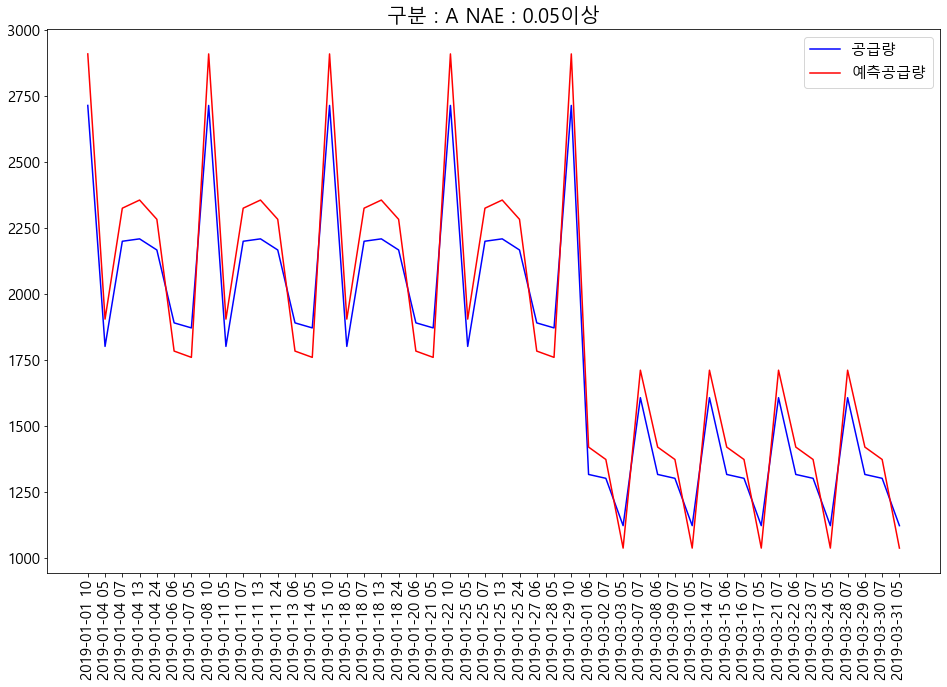

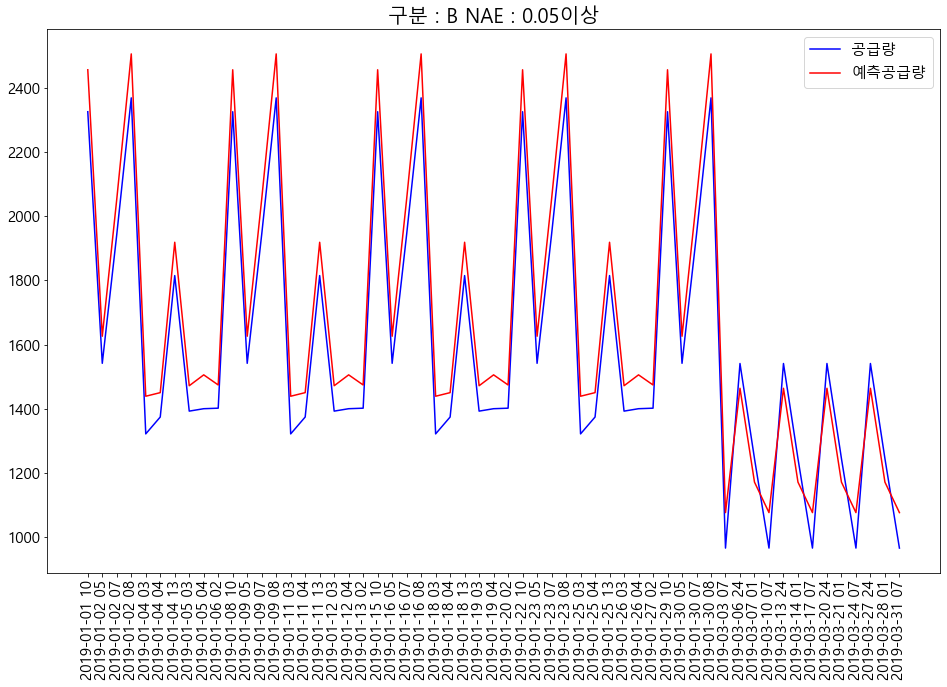

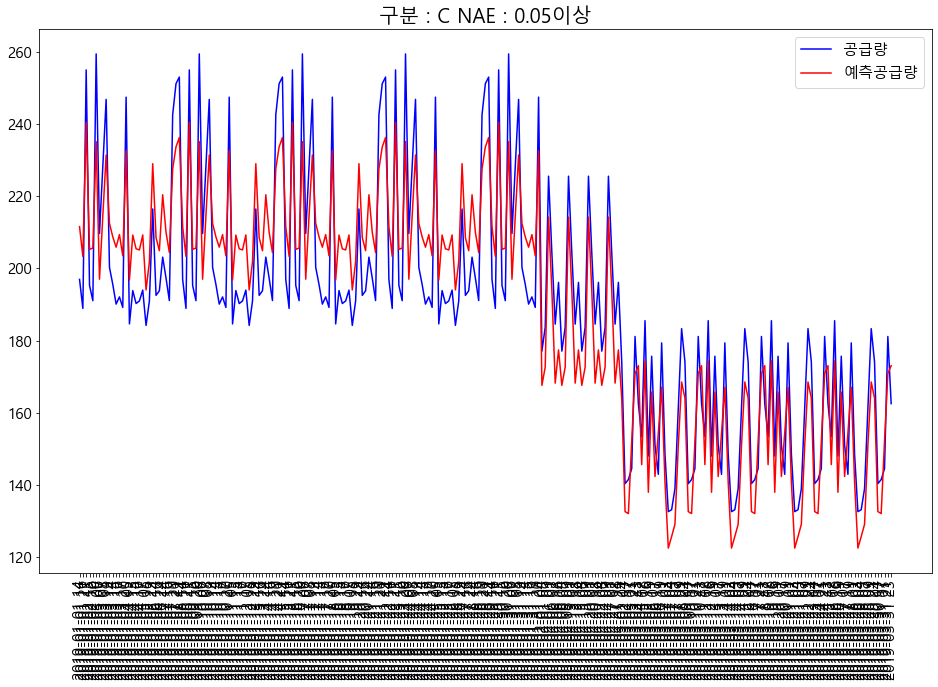

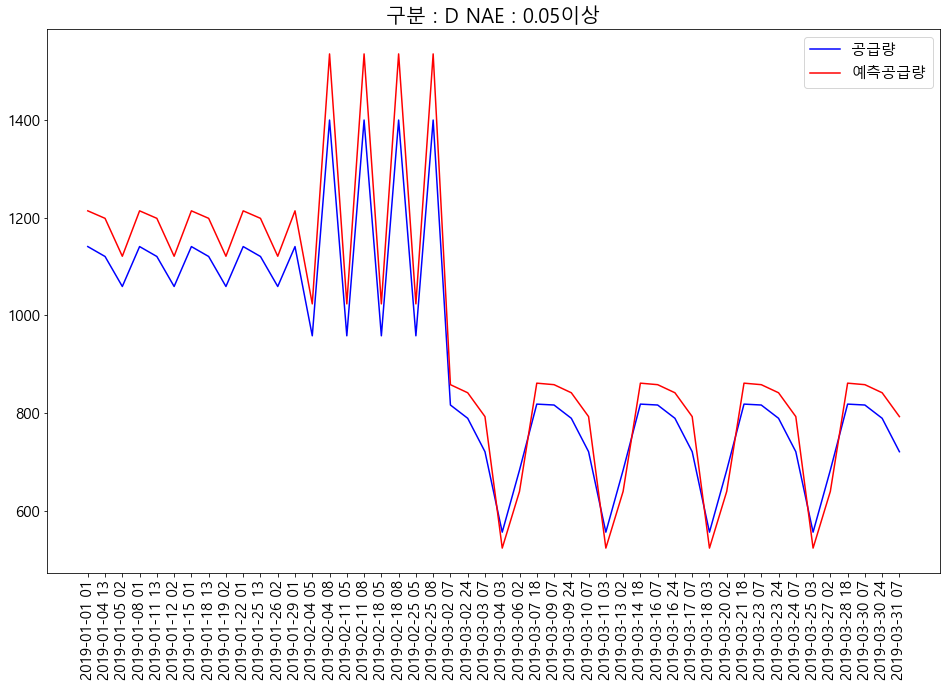

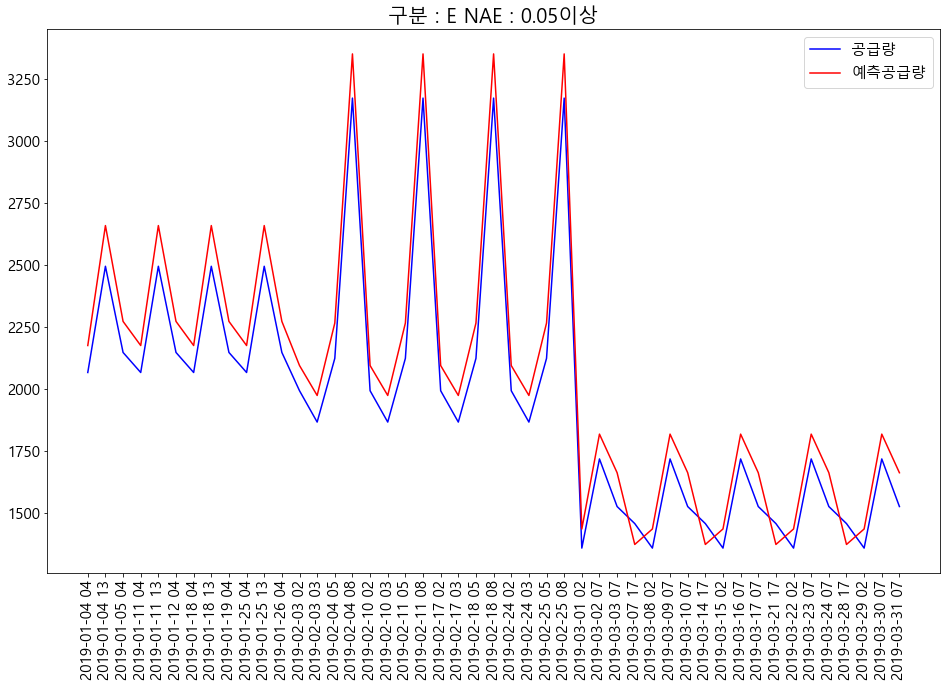

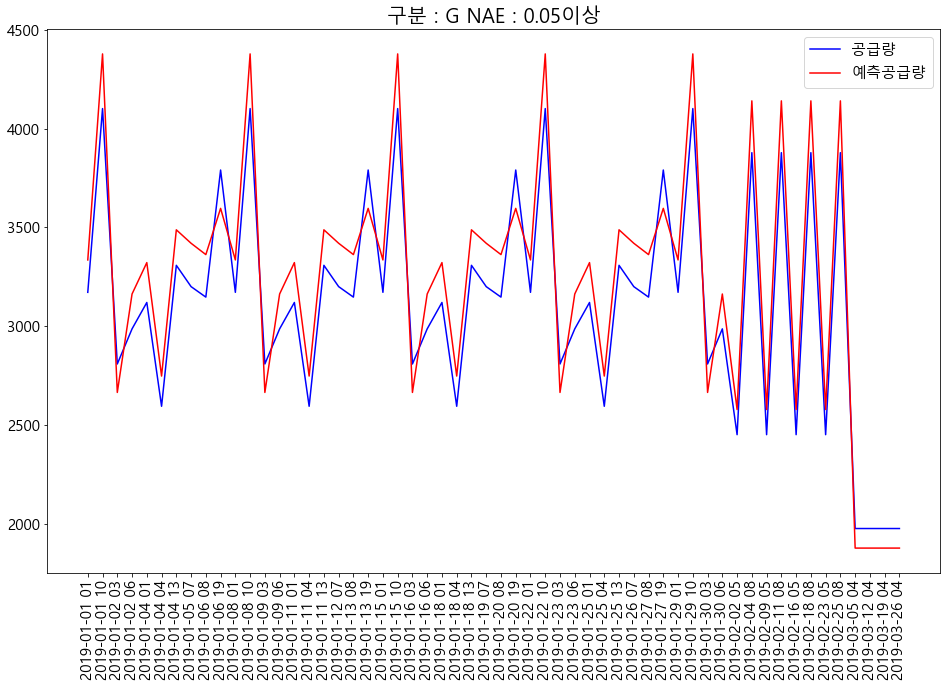

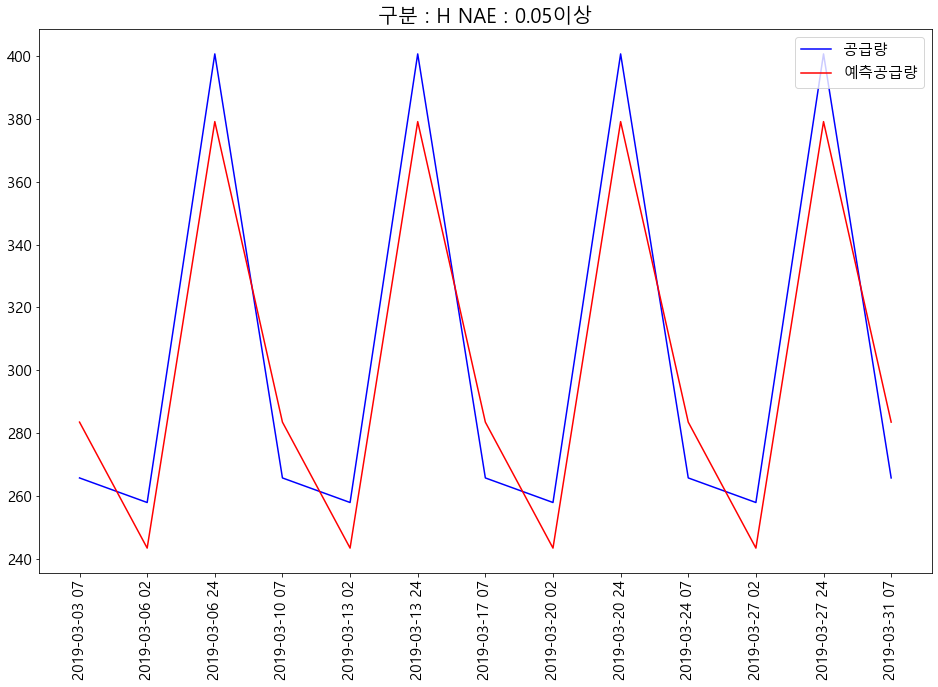

In [58]:
# vis_nae(NAE 셋, NAE 조건 값(NAE >= 값))
# NAE 0.05이상인 샘플 시각화
vis_nae(all_nae, 0.05)